In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action="ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import roc_curve, auc

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

C:\Users\agarw\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#importing data from the dataset
df = pd.read_csv(r"C:\Users\agarw\OneDrive\Desktop\Dissertation\data.csv")

In [3]:
#checking for bankrupt companies 0 is non-bankrupt and 1 is bankrupt
bankrupt_data = df['Bankrupt?'].value_counts()
bankrupt_data

Bankrupt?
0    6599
1     220
Name: count, dtype: int64

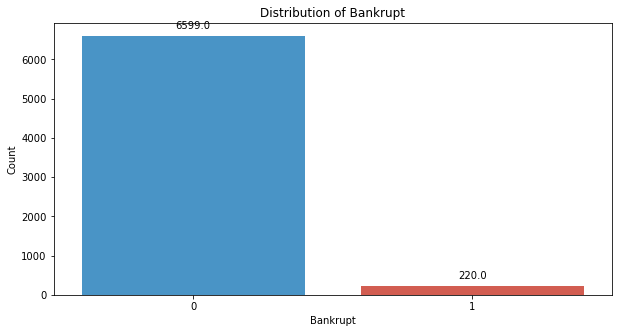

In [4]:
#Distribution representation
plt.figure(figsize = (10,5))
colors = ["#3498db", "#e74c3c"]
ax = sns.countplot(x=df['Bankrupt?'], data=df,palette=colors)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
# Add labels and title
plt.xlabel('Bankrupt')
plt.ylabel('Count')
plt.title('Distribution of Bankrupt')

# Show the plot
plt.show()

In [5]:
# seperate the Bankrupt label from the dataset 
y = df['Bankrupt?']
X = df.drop(['Bankrupt?'], axis = 1)

In [6]:
# divinding our dataset into training dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

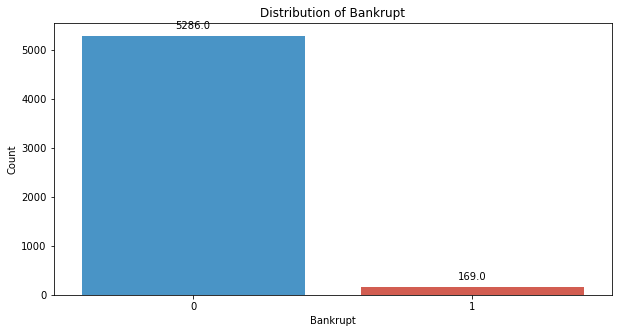

In [7]:
#Distribution representation
plt.figure(figsize = (10,5))
colors = ["#3498db", "#e74c3c"]
ax = sns.countplot(x=y_train, data=df,palette=colors)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
# Add labels and title
plt.xlabel('Bankrupt')
plt.ylabel('Count')
plt.title('Distribution of Bankrupt')

# Show the plot
plt.show()

In [8]:
# divinding our dataset into testing and validation 
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:
smote = SMOTE(sampling_strategy=1, random_state=42)

In [10]:
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

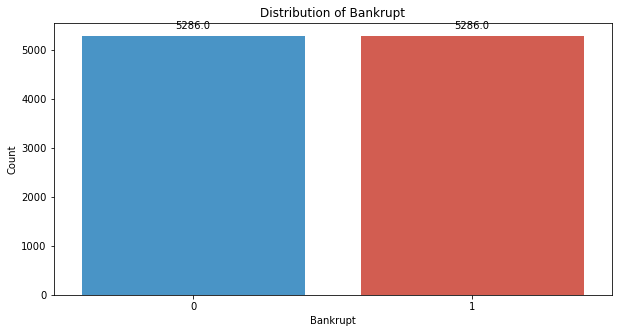

In [11]:
#Distribution representation
plt.figure(figsize = (10,5))
colors = ["#3498db", "#e74c3c"]
ax = sns.countplot(x=y_train_resampled, data=df,palette=colors)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
# Add labels and title
plt.xlabel('Bankrupt')
plt.ylabel('Count')
plt.title('Distribution of Bankrupt')

# Show the plot
plt.show()

In [12]:
# Standardize the data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [13]:
# Train a Deep Belief Network (DBN) using BernoulliRBM
rbm = BernoulliRBM(n_components=95, n_iter=10, random_state=42)
rbm.fit(X_train_resampled)

BernoulliRBM(n_components=95, random_state=42)

In [14]:
# Transform the data using the trained RBM
X_train_transformed = rbm.transform(X_train_resampled)
X_test_transformed = rbm.transform(X_test)
X_val_transformed = rbm.transform(X_val)

In [15]:
#CLassifier
clf = RandomForestClassifier(n_estimators=100,criterion = "entropy", max_depth= 3, random_state=42)

In [16]:
# Train an AdaBoost classifier on top of the transformed data
adaboost = AdaBoostClassifier(base_estimator=clf,n_estimators=50,learning_rate=1, random_state=42)
adaboost.fit(X_train_transformed, y_train_resampled)

AdaBoostClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                         max_depth=3,
                                                         random_state=42),
                   learning_rate=1, random_state=42)

In [17]:
y_val_pred = adaboost.predict(X_val_transformed)

In [18]:
# Evaluate the model's performance on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1_value = f1_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)

print("Accuracy", val_accuracy)
print("Precision", precision)
print("Recall", recall)
print("F1 Score", f1_value)
print("Validation Classification Report:\n", val_report)

Accuracy 0.8020527859237536
Precision 0.12418300653594772
Recall 0.95
F1 Score 0.21965317919075145
Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89       662
           1       0.12      0.95      0.22        20

    accuracy                           0.80       682
   macro avg       0.56      0.87      0.55       682
weighted avg       0.97      0.80      0.87       682



In [19]:
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix")
print(conf_matrix)

Confusion Matrix
[[528 134]
 [  1  19]]


In [20]:
y_test_pred = adaboost.predict(X_test_transformed)

In [21]:
# Evaluate the model's performance on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1_value = f1_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print("Accuracy", test_accuracy)
print("Precision", precision)
print("Recall", recall)
print("F1 Score", f1_value)
print("Test Classification Report:\n", test_report)

Accuracy 0.8049853372434017
Precision 0.17721518987341772
Recall 0.9032258064516129
F1 Score 0.29629629629629634
Test Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.80      0.89       651
           1       0.18      0.90      0.30        31

    accuracy                           0.80       682
   macro avg       0.59      0.85      0.59       682
weighted avg       0.96      0.80      0.86       682



In [22]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix")
print(conf_matrix)

Confusion Matrix
[[521 130]
 [  3  28]]


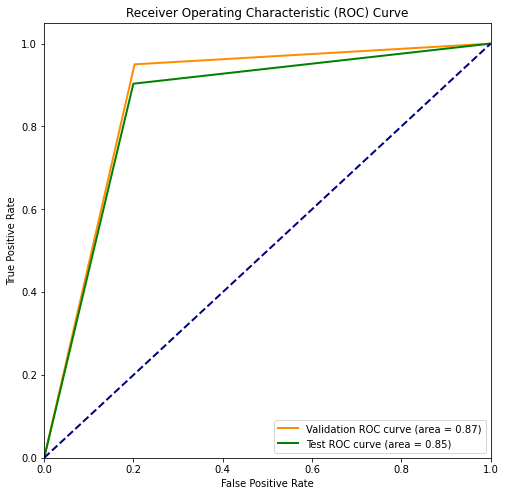

In [23]:
# Compute ROC curve and ROC area for each class
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred)
roc_auc_val = auc(fpr_val, tpr_val)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'Validation ROC curve (area = {roc_auc_val:.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()